In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', color_codes = True)

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [3]:
ps = ps[['Date', 'User', 'Post patch?', 'Notes', 'PCR cycles', 'SM_QC_PF', 'Resolution index', 'Bad dates']]
ps = ps[ps['PCR cycles'] == 21]
ps['Date'] = pd.to_datetime(ps['Date'], format = '%y%m%d')
ps = ps[ps['Bad dates'] != 'x']
ps = ps.drop('Bad dates', 1)
ps = ps[ps['SM_QC_PF'] != 'cnt']
ps.dropna(subset = ['Post patch?', 'SM_QC_PF'], inplace = True)
ps['Post patch?'] = ps['Post patch?'].astype('category')
ps['SM_QC_PF'].value_counts()

pass    709
fail    182
Name: SM_QC_PF, dtype: int64

#### Total # of experiments since April 20 

In [4]:
total = ps["SM_QC_PF"].count()
total

891

#### # of experiments passing smqc 

In [5]:
passing = ps[ps['SM_QC_PF'] == 'pass']
passed = passing['SM_QC_PF'].count()
passed

709

#### # of experiments with Resolution index >= 0.8 

In [6]:
high_res = ps[ps['Resolution index'] >= 0.8]
hi_res = high_res['Resolution index'].count()
hi_res

136

#### percentage of experiments with Resolution index >= 0.8 

In [7]:
pct_ttl = float(hi_res) / total
print 'percentage of total samples with Resolution index >= 0.8 =', pct_ttl
pct_pass = float(hi_res) / passed
print 'percentage of smqc pass samples with Resolution index >= 0.8 =', pct_pass

percentage of total samples with Resolution index >= 0.8 = 0.152637485971
percentage of smqc pass samples with Resolution index >= 0.8 = 0.191819464034


#### Filtering to only experiments that have Resolution index data 

In [8]:
ps.dropna(subset = ['Resolution index'], inplace = True)
ps.tail()

,Date,User,Post patch?,Notes,PCR cycles,SM_QC_PF,Resolution index
5433,2017-06-01,P1,No-Seal,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",21.0,pass,0.660082
5434,2017-06-01,P1,Partial-Nucleus,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",21.0,pass,0.556320
5435,2017-06-01,P1,Nucleated,"Fluorescence in Pipette,Cell Dimmed Small Bu...",21.0,pass,0.556320
5436,2017-06-01,P1,Entire-Cell,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",21.0,pass,0.860881
5440,2017-06-01,P2,No-Seal,Fluorescence in Pipette Large Bubbles Pretty s...,21.0,pass,0.660082


#### swarm-plot with Seaborn 

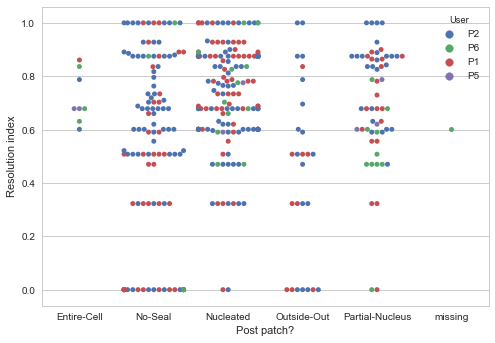

In [9]:
sns.swarmplot(x='Post patch?', y='Resolution index', hue='User', data=ps)

#### box-plot with Seaborn 

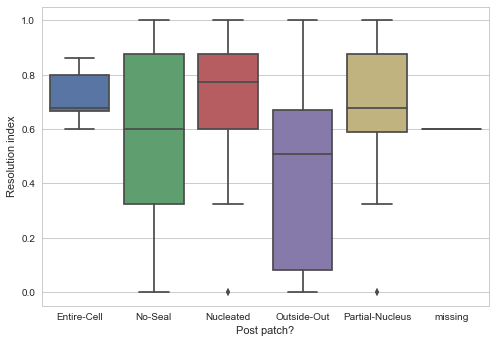

In [10]:
sns.boxplot(x='Post patch?', y='Resolution index', data=ps)

#### violin-plot with Seaborn 

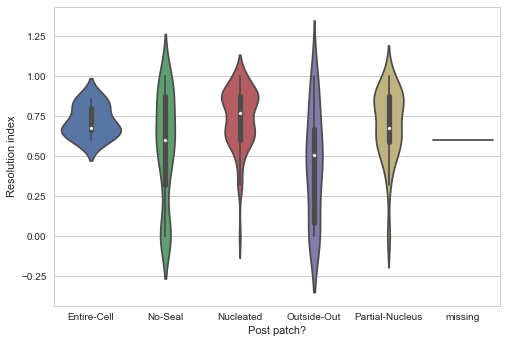

In [11]:
sns.violinplot(x='Post patch?', y='Resolution index', data=ps)

#### violin-plot and swarm-plot with Seaborn 

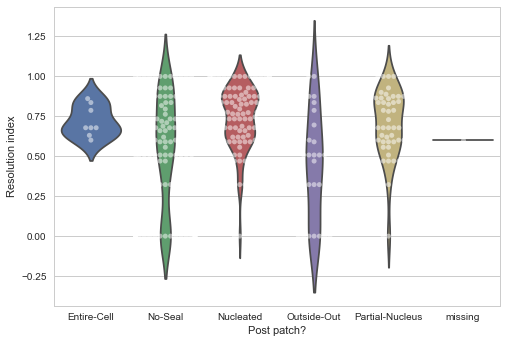

In [12]:
sns.violinplot(x='Post patch?', y='Resolution index', data=ps, inner=None)
sns.swarmplot(x='Post patch?', y='Resolution index', data=ps, color='w', alpha=.5)

In [13]:
res_1 = ps[ps['Resolution index'] == 1]
res_1.head()

,Date,User,Post patch?,Notes,PCR cycles,SM_QC_PF,Resolution index
4775,2017-04-21,P2,Nucleated,Fluorescence in Pipette,21.0,pass,1.0
4803,2017-04-24,P2,No-Seal,NaN,21.0,pass,1.0
4838,2017-04-25,P2,Nucleated,no bubbles during expulsion.,21.0,pass,1.0
4920,2017-04-28,P2,Partial-Nucleus,no bubbles during expulsion.,21.0,pass,1.0
4946,2017-05-01,P6,No-Seal,NaN,21.0,pass,1.0


#### first attempt at plotting with Plotly 

In [20]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.figure_factory as ff
import plotly.graph_objs as go

table = ff.create_table(ps)
#py.iplot(table, filename='table1')
dots = go.Scatter(x=ps['Post patch?'], y=ps['Resolution index'], mode='markers', name='dots')
data = [dots]
py.iplot(data, name='scatter')
#py.iplot(plotly, x='Post patch?', y='Resolution index')

#### violin and rug plots with Plotly 

In [17]:
from plotly.graph_objs import graph_objs
df = ps[['Post patch?','Resolution index']]
df = df[df['Post patch?'] != 'missing'] #there was only one data point for "missing" which was causing an error with violin plot
fig = ff.create_violin(df, data_header='Resolution index', group_header='Post patch?', height=500, width=800)
py.iplot(fig, filename='violin plot')


#### using regex to search for and extract exact strings to get bubble conditions from Notes field.    

In [9]:
ps.dropna(subset = ['Notes'], inplace = True)
ps = ps[ps['Notes'].str.contains('Bubbles')]
a_regex = '(No Bubbles|Small Bubbles,Medium Bubbles|Small Bubbles,Large Bubbles|Small Bubbles|Medium Bubbles,Large Bubbles|Medium Bubbles|Large Bubbles,Solution in Pipette Shank|Large Bubbles)'
#a_regex = '(Large Bubbles,Solution in Pipette Shank|Large Bubbles|No Bubbles|Small Bubbles,Medium Bubbles|Small Bubbles,Large Bubbles|Small Bubbles||Medium Bubbles,Large Bubbles|Medium Bubbles)'
#replacements = {'Large Bubbles,Solution in Pipette Shank':'Solution in Pipette Shank', 'Large Bubbles':'Large Bubbles', 'No Bubbles':'No Bubbles', 'Small Bubbles,Medium Bubbles':'Medium Bubbles', 'Small Bubbles,Large Bubbles':'Large Bubbles', 'Small Bubbles':'Small Bubbles', 'Medium Bubbles, Large Bubbles':'Large Bubbles', 'Medium Bubbles':'Medium Bubbles'}
ps['Bubbles'] = ps['Notes'].str.extract(a_regex).fillna('')
#ps['Bubbles'] = ps['Bubbles'].apply(lambda x: replacements.get(x,''))
ps.head()


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,Date,User,Post patch?,Notes,PCR cycles,SM_QC_PF,Resolution index,Bubbles
5211,2017-05-16,P1,Nucleated,Small Bubbles,21.0,pass,1.000000,Small Bubbles
5215,2017-05-16,P2,Outside-Out,Small Bubbles,21.0,pass,1.000000,Small Bubbles
5216,2017-05-16,P2,Nucleated,No Bubbles,21.0,pass,0.601033,No Bubbles
5217,2017-05-16,P2,Nucleated,No Bubbles,21.0,pass,0.875031,No Bubbles
5228,2017-05-17,P1,Nucleated,"Small Bubbles,Medium Bubbles",21.0,pass,0.825809,"Small Bubbles,Medium Bubbles"


#### swarm-plot of post patch vs resolution index by bubble condition 

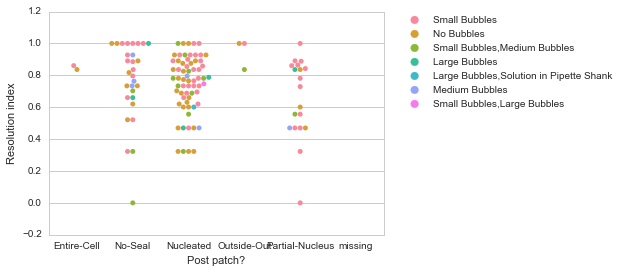

In [10]:
sns.swarmplot(x='Post patch?', y='Resolution index', hue='Bubbles', data=ps)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

In [11]:
def bubb_filter(x):
    df = ps[ps['Bubbles'] == x]
    return df

def pp_filter(y):
    df2 = ps[ps['Post patch?'] == y]
    return df2

def hires_filter(z):
    df3 = z[z['Resolution index'] >= 0.8]
    return df3

def get_count(v):
    count = v['Bubbles'].count()
    return count

def calc_pct(passing, total):
    pct = float(get_count(passing)) / get_count(total)
    return pct
    


#### percentage with resolution index >=0.8 by bubble and post patch condition 

In [12]:
nb = bubb_filter('No Bubbles')
nbhr = hires_filter(bubb_filter('No Bubbles'))
nbhrpp = calc_pct(nbhr,nb)
print 'no bubbles hi-res pct =', nbhrpp

no bubbles hires pct = 0.447368421053


In [13]:
sb = bubb_filter('Small Bubbles')
sbhr = hires_filter(bubb_filter('Small Bubbles'))
sbhrpp = calc_pct(sbhr,sb)
print 'small bubbles hi-res pct =', sbhrpp

small bubbles hires pct = 0.584905660377


In [14]:
nu = pp_filter('Nucleated')
nuhr = hires_filter(pp_filter('Nucleated'))
nuhrpp = calc_pct(nuhr,nu)
print 'nucleated patch hi-res pct =', nuhrpp

nucleated patch hires pct = 0.415384615385


In [15]:
ns = pp_filter('No-Seal')
nshr = hires_filter(pp_filter('No-Seal'))
nshrpp = calc_pct(nshr,ns) 
print 'no-seal hi-res pct =', nshrpp

no-seal hires pct = 0.51724137931
